In [11]:
import re, datetime as dt, pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt, seaborn as sns

sns.set_theme()
pd.set_option('display.max_columns', 500)

In [12]:
# Base Rate
rates = pd.read_csv(r'Bank Rate history and data  Bank of England Database.csv', parse_dates=['Date Changed'])

# Take monthly average to match CPI  
rates['Rate'] = rates['Rate'] / 100 
rates['month_start'] = [i - dt.timedelta(rates.loc[n, 'Date Changed'].day - 1) for n, i in enumerate(rates['Date Changed'])]

rates = rates.groupby(['month_start'])['Rate'].mean()

In [13]:
# Import & filter CPI
inflation = pd.read_csv(r'mm23.csv', low_memory=False).iloc[857:, :].reset_index(drop=True).infer_objects()
inflation = inflation[['Title', *[col for col in inflation.columns if re.search('ALL ITEMS', col)], ]]

# Parse dates
inflation = inflation.rename(columns={'Title': 'Date'}).copy()
inflation['Date'] = pd.to_datetime(inflation['Date'])

# Merge historical & current
inflation['CPI_annual'] = [inflation.loc[n,'CPI HISTORICAL MODELLED ANNUAL RATE 00: ALL ITEMS'] if pd.isna(i) 
                            else i for n, i in enumerate(inflation['CPI ANNUAL RATE 00: ALL ITEMS 2015=100'])] 

inflation['CPI_index'] = [inflation.loc[n,'CPI HISTORICAL MODELLED INDEX 00: ALL ITEMS 1965=100'] if pd.isna(i) 
                            else i for n, i in enumerate(inflation['CPI INDEX 00: ALL ITEMS 2015=100'])]

inflation['CPI_annual'] = inflation['CPI_annual'].astype(float) / 100
inflation['CPI_index'] = inflation['CPI_index'].astype(float)

# Filter & re-index
inflation = inflation[['Date', 'CPI_annual', 'CPI_index']].set_index('Date')
inflation.index.name = None

# Join
inflation = inflation.join(rates)

inflation.sort_index(ascending=False).head()

,CPI_annual,CPI_index,Rate
2022-11-01,0.107,126.7,0.0300
2022-10-01,0.111,126.2,NaN
2022-09-01,0.101,123.8,0.0225
2022-08-01,0.099,123.1,0.0175
2022-07-01,0.101,122.5,NaN


In [14]:
# Fill missing rate data where rate was unchanged throughout
inflation = inflation.reset_index().rename(columns={'index': 'date'})

for i in inflation.index:
    if not pd.isna(inflation.loc[i, 'Rate']):
        val = inflation.loc[i, 'Rate']
    else:
        inflation.loc[i, 'Rate'] = val

inflation = inflation.set_index('date')
inflation.sort_index(ascending=False).head()

,CPI_annual,CPI_index,Rate
date,,,
2022-11-01,0.107,126.7,0.0300
2022-10-01,0.111,126.2,0.0225
2022-09-01,0.101,123.8,0.0225
2022-08-01,0.099,123.1,0.0175
2022-07-01,0.101,122.5,0.0125


In [15]:
# Correlations
inflation.corr(numeric_only=False)

,CPI_annual,CPI_index,Rate
CPI_annual,1.000000,0.401076,0.597337
CPI_index,0.401076,1.000000,0.535307
Rate,0.597337,0.535307,1.000000


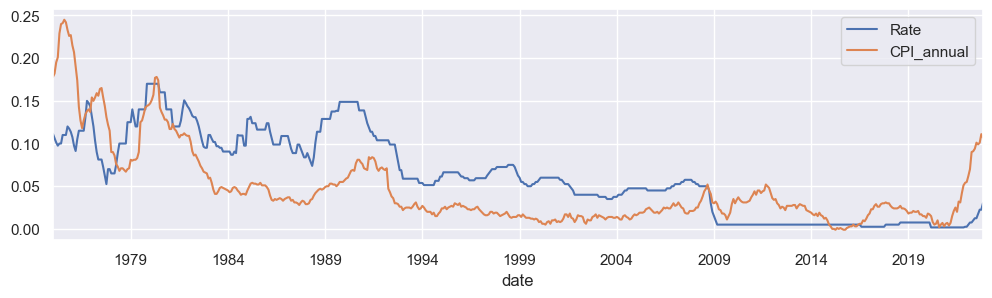

In [16]:
# Plot
inflation[['Rate', 'CPI_annual']].plot(figsize=(12,3));

In [17]:
# Annual correlations
inflation['year'] = inflation.index.year

corrs = {}
for year in inflation['year'].unique():
    tmp = inflation[inflation['year'] == year][['CPI_annual', 'Rate']]
    corrs.update({year: tmp.corr().loc['CPI_annual', 'Rate']})

 Score : 41.52 % 
 Coefficients: [  0.          -0.72018619  16.16983388 -50.50387024] 
 Intercept : 0.026804255788153097


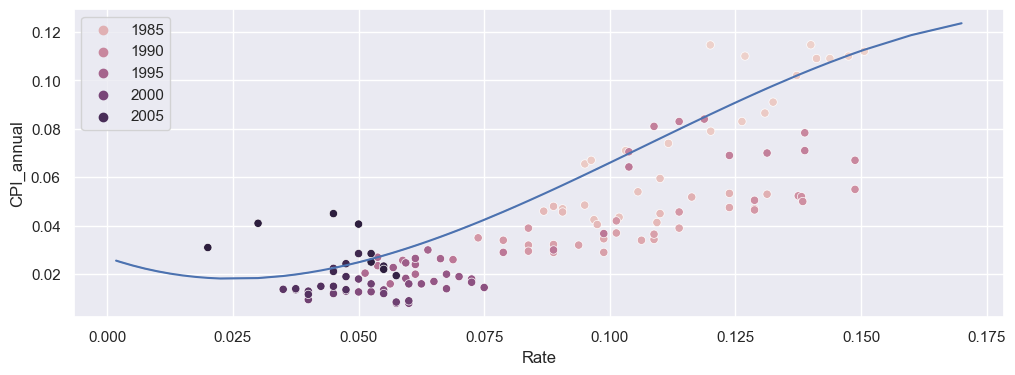

In [33]:
# Regression model
plot_data = pd.DataFrame(inflation.groupby(['year', 'Rate'])['CPI_annual'].mean()).reset_index()
plot_data = plot_data[(plot_data['year'] > 1980) & (plot_data['year'] < 2009)]

x=inflation[['Rate']]
y=inflation['CPI_annual']

# Preprocess for polynomial 
poly_features = PolynomialFeatures(degree = 3)
x_poly = poly_features.fit_transform(x)

model = LinearRegression()
model.fit(x_poly, y)

y_pred = model.predict(x_poly)

print(
    f' Score : {round(100 * r2_score(y, y_pred), 2)} %', '\n',
    f'Coefficients: {model.coef_}', '\n',
    f'Intercept : {model.intercept_}'
)

plt.figure(figsize=(12,4))

sns.scatterplot(
    data=plot_data,
    x = 'Rate', 
    y = 'CPI_annual', 
    hue='year',
    )

sns.lineplot(
    x = inflation['Rate'], 
    y = y_pred  
    );

In [36]:
inflation['Rate_p'] = model.predict(poly_features.fit_transform(inflation[['Rate']])) + model.intercept_

(inflation[['Rate', 'Rate_p']].sort_index(ascending=False).head(12) * 100).round(2)

,Rate,Rate_p
date,,
2022-11-01,3.00,4.52
2022-10-01,2.25,4.50
2022-09-01,2.25,4.50
2022-08-01,1.75,4.57
2022-07-01,1.25,4.70
2022-06-01,1.25,4.70
2022-05-01,1.00,4.80
2022-04-01,0.75,4.91
2022-03-01,0.75,4.91


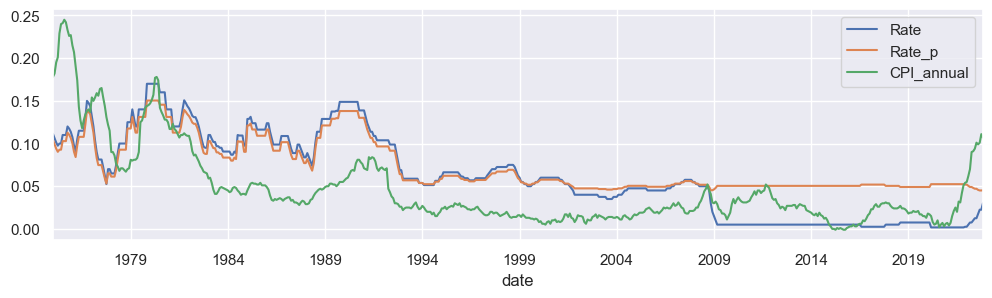

In [37]:
# Plot
inflation[['Rate', 'Rate_p', 'CPI_annual']].plot(figsize=(12,3));